# Infectious Disease Dynamics: Final Project

In [1]:
from typing import Any
import numpy as np
from scipy.special import logit
from scipy.special import expit
from numpy.random import default_rng
from scipy.stats import binom
import matplotlib.pyplot as plt

rng = default_rng(seed=42)

population = 100_000
num_particles = 100
num_time_steps = 12 * 5

horrible_guess = -1e10

target_beta = 2 / 5
target_gamma = 1 / 5
target_s_init = 0.95
target_i_init = 0.01
target_rho = 0.5
target_season = .9
target_peak = 6

target_vector = np.array([
    np.log(target_beta),
    np.log(target_gamma),
    logit(target_s_init),
    logit(target_i_init / (1 - target_s_init)),
    logit(target_rho),
    logit(target_season),
    logit(target_peak / 12)
])

proposal_standard_dev = np.array([0.05, 0.05, 0.2, 0.2, 0.2, 0.2, 0.2])
num_params = len(proposal_standard_dev)

In [2]:
def sir_out(params: np.ndarray) -> np.ndarray:
    beta = np.exp(params[0])
    gamma = np.exp(params[1])
    s_init_frac = expit(params[2])
    i_init_frac = expit(params[3]) * (1 - s_init_frac)

    rho = expit(params[4])
    season = expit(params[5])
    peak = 12 * expit(params[6])

    s_init = round(s_init_frac * population)
    i_init = round(i_init_frac * population)
    r_init = population - (s_init + i_init)

    # Columns: S, I, R, NewI, NewR, ObsCases, InfectionRate
    sir_population = np.full((num_time_steps + 1, 7), np.nan)

    sir_population[0, 0] = s_init
    sir_population[0, 1] = i_init
    sir_population[0, 2] = r_init

    for r_num in range(num_time_steps):
        tmp_s = sir_population[r_num, 0]
        tmp_i = sir_population[r_num, 1]
        tmp_r = sir_population[r_num, 2]

        tmp_seasonal_beta = beta * (1 + season * np.sin(2 * np.pi * (r_num + peak) / 12))

        infection_prob = 1 - np.exp(-tmp_seasonal_beta * tmp_i / population)
        recovery_prob = 1 - np.exp(-gamma)
        sir_population[r_num, 6] = infection_prob

        s_to_i = rng.binomial(int(tmp_s), infection_prob)
        i_to_r = rng.binomial(int(tmp_i), recovery_prob)

        sir_population[r_num + 1, 0] = tmp_s - s_to_i
        sir_population[r_num + 1, 1] = tmp_i + s_to_i - i_to_r
        sir_population[r_num + 1, 2] = tmp_r + i_to_r

        sir_population[r_num, 3] = s_to_i
        sir_population[r_num, 4] = i_to_r
        
        observed_cases = rng.binomial(s_to_i, rho)
        sir_population[r_num, 5] = observed_cases

    return sir_population

# Run the simulation
data = sir_out(target_vector)


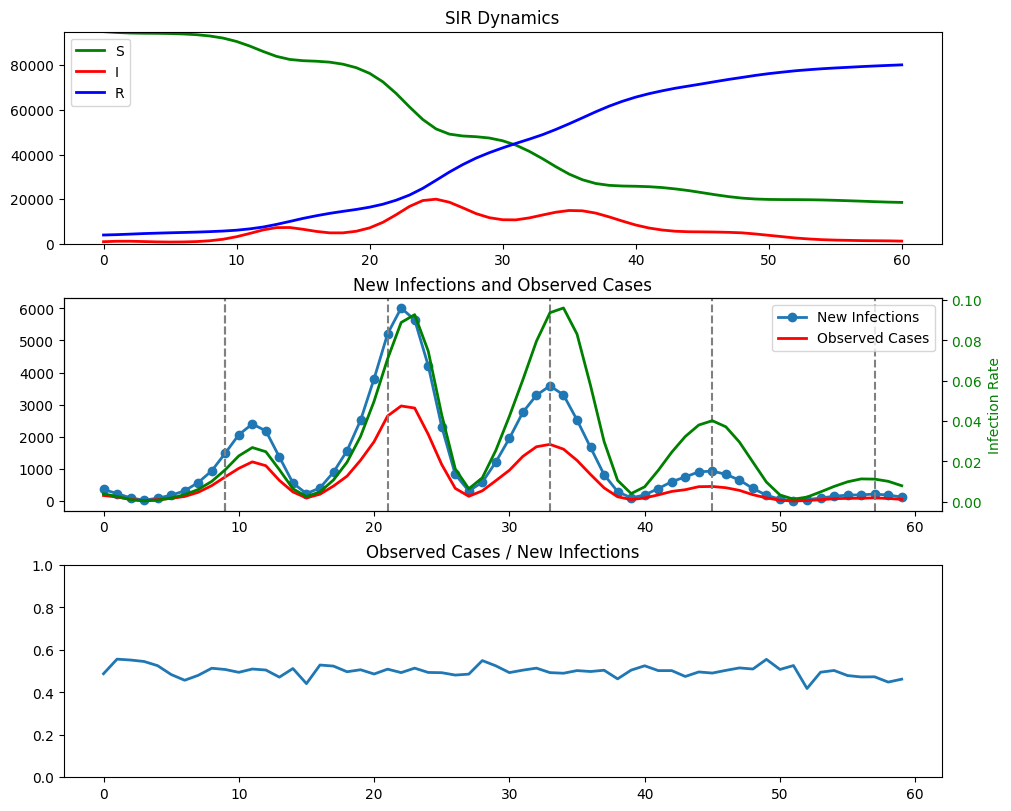

In [3]:
# Set up 3 vertically stacked plots with consistent margins
fig, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

# First plot: S, I, R over time
axs[0].plot(data[:, 0], label='S', color='green', linewidth=2)
axs[0].plot(data[:, 1], label='I', color='red', linewidth=2)
axs[0].plot(data[:, 2], label='R', color='blue', linewidth=2)
axs[0].set_ylim(0, np.nanmax(data[:, 0:3]))
axs[0].set_title("SIR Dynamics")
axs[0].legend()

# Second plot: New Infections and Observed Cases
axs[1].plot(data[:, 3], marker='o', linestyle='-', linewidth=2, label='New Infections')
axs[1].plot(data[:, 5], color='red', linewidth=2, label='Observed Cases')

axs[1].axvline(x=9, linestyle='--', color='gray')  # equivalent to abline at v=9,21,33,45,57
for x in range(9, 9 + 12 * 4 + 1, 12):
    axs[1].axvline(x=x, linestyle='--', color='gray')

axs[1].set_title("New Infections and Observed Cases")
axs[1].legend(loc='upper right')

# Overlay the infection rate curve from column 6
ax2 = axs[1].twinx()
ax2.plot(data[:, 6], color='green', linewidth=2, label='Infection Rate')

ax2.set_ylabel("Infection Rate", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Third plot: Observed / New Infections (reporting rate estimate)
ratio = np.divide(data[:, 5], data[:, 3], out=np.zeros_like(data[:, 5]), where=data[:, 3]!=0)

axs[2].plot(ratio, linewidth=2)
axs[2].set_ylim(0, 1)
axs[2].set_title("Observed Cases / New Infections")

plt.show()

# Equivalent to R: observed_data <- head(data[,6], -1)
observed_data = data[:-1, 5]


In [4]:
def run_one_timestep(
    current_latent_states: np.ndarray,
    which_month: int,
    params: np.ndarray,
) -> np.ndarray:
    
    beta = np.exp(params[0])
    gamma = np.exp(params[1])
    season = expit(params[5])
    peak = 12 * expit(params[6])

    sir_population_by_particle = np.full((num_particles, 2, 4), np.nan)

    # Initialize current state for each particle
    sir_population_by_particle[:, 0, 0] = current_latent_states[:, 0]  # S
    sir_population_by_particle[:, 0, 1] = current_latent_states[:, 1]  # I
    sir_population_by_particle[:, 0, 2] = current_latent_states[:, 2]  # R

    # Compute seasonal transmission probability
    seasonal_multiplier = 1 + season * np.sin(2 * np.pi * (which_month + peak) / 12)
    infection_rate = beta * seasonal_multiplier * sir_population_by_particle[:, 0, 1] / population
    infection_prob = 1 - np.exp(-infection_rate)

    # Draw infections and recoveries
    s_to_i = rng.binomial(
        n=sir_population_by_particle[:, 0, 0].astype(int),
        p=infection_prob
    )
    
    recovery_prob = 1 - np.exp(-gamma)
    i_to_r = rng.binomial(
        n=sir_population_by_particle[:, 0, 1].astype(int),
        p=recovery_prob
    )

    # Update states for next timestep
    sir_population_by_particle[:, 1, 0] = sir_population_by_particle[:, 0, 0] - s_to_i  # Susceptible
    sir_population_by_particle[:, 1, 1] = sir_population_by_particle[:, 0, 1] + s_to_i - i_to_r  # infectious
    sir_population_by_particle[:, 1, 2] = sir_population_by_particle[:, 0, 2] + i_to_r  # Recovered
    sir_population_by_particle[:, 1, 3] = s_to_i  # new infections

    # next timestep
    return sir_population_by_particle[:, 1, :] 


In [5]:
def run_smc(
    sir_out_last_month: np.ndarray,
    current_month: int,
    params: np.ndarray,
    observed_data: np.ndarray
) -> dict[str, np.ndarray]:
    
    rho = expit(params[4])
    
    # Run one timestep of the latent SIR model
    tmp_latent_states = run_one_timestep(
        current_latent_states=sir_out_last_month,
        which_month=current_month,
        params=params
    )
    predicted_infections = tmp_latent_states[:, 3].astype(int)  # new infections
    observed_cases = int(observed_data[current_month])
    
    # Compute likelihood of observed cases given predicted infections
    tmp_likelihood = np.array([
        binom.pmf(observed_cases, pred, rho) if pred >= observed_cases else 0.0
        for pred in predicted_infections
    ])
    
    # If all likelihoods are zero, reset to a small constant
    if np.max(tmp_likelihood) == 0:
        tmp_likelihood = np.full(num_particles, 1e-10)

    # Normalize to form a probability distribution
    weights = tmp_likelihood / np.sum(tmp_likelihood)

    # Resample particles with replacement according to weights
    sampled_indices = rng.choice(num_particles, size=num_particles, replace=True, p=weights)
    sir_out_this_month = tmp_latent_states[sampled_indices, :]
    
    # Package result
    out = {
        "new_latent_states": sir_out_this_month,
        "new_log_likelihoods": tmp_likelihood[sampled_indices],
        "sampled_particles": sampled_indices
    }
    return out


In [6]:
def initialize_array(params: np.ndarray) -> np.ndarray:
    s_init_frac = expit(params[2])
    i_init_frac = expit(params[3]) * (1 - s_init_frac)

    s_init = round(s_init_frac * population)
    i_init = round(i_init_frac * population)
    r_init = population - (s_init + i_init)

    # Create array of shape (num_particles, num_time_steps + 1, 4)
    sir_out_all_months = np.full((num_particles, num_time_steps + 1, 4), np.nan)

    # Set initial state
    sir_out_all_months[:, 0, 0] = s_init  # Susceptible
    sir_out_all_months[:, 0, 1] = i_init  # Infected
    sir_out_all_months[:, 0, 2] = r_init  # Recovered
    sir_out_all_months[:, 0, 3] = 0    # New infections

    return sir_out_all_months


In [7]:
def calc_log_likelihood(
    params: np.ndarray,
    observed_data: np.ndarray
) -> float:
    sir_out_all_months = initialize_array(params)
    val = 0.0

    for month_step in range(1, num_time_steps + 1):
        tmp_out = run_smc(
            sir_out_last_month=sir_out_all_months[:, month_step - 1, :],
            current_month=month_step - 1,
            params=params, 
            observed_data=observed_data
        )

        # Resample all history up to this month based on sampled particles
        for t in range(month_step):
            sir_out_all_months[:, t, :] = sir_out_all_months[tmp_out["sampled_particles"], t, :]

        # Save new latent states
        sir_out_all_months[:, month_step, :] = tmp_out["new_latent_states"]

        # Add log of mean likelihood
        mean_likelihood = np.mean(tmp_out["new_log_likelihoods"])
        new_val = np.log(mean_likelihood if mean_likelihood > 0 else 1e-10)  # avoid log(0)
        val += new_val

    return val, sir_out_all_months


In [8]:
def proposal_draw(proposal_standard_dev: np.ndarray) -> np.ndarray:
    # Using multivariate normal with mean 0 and diagonal covariance matrix
    vec = rng.multivariate_normal(mean=np.zeros(num_params), cov=np.diag(proposal_standard_dev**2))
    return vec


def propose_new_val(
    current_parameter_guess: np.ndarray,
    proposal_standard_dev: np.ndarray,
    observed_data: np.ndarray,
) -> dict[str, np.ndarray]:
    new_parameter_guess = current_parameter_guess + proposal_draw(proposal_standard_dev)
    new_chain_info = calc_log_likelihood(new_parameter_guess, observed_data)
    out = {
        "new_parameter_guess": new_parameter_guess,
        "new_chain_info": new_chain_info
    }
    return out


In [9]:
def metropolis_hastings_step(
    current_parameter_guess: np.ndarray,
    new_parameter_guess: np.ndarray,
    current_log_likelihood: float,
    new_log_likelihood: float,
    current_latent: np.ndarray,
    new_latent: np.ndarray,
) -> dict[str, Any]:
    alpha = np.exp(new_log_likelihood - current_log_likelihood)
    r_num = rng.uniform()  # use np.random.uniform() if not using a seeded rng

    accept_step = r_num < alpha

    if accept_step:
        next_parameter_guess = new_parameter_guess
        next_log_likelihood = new_log_likelihood
        next_latent = new_latent

    else:
        next_parameter_guess = current_parameter_guess
        next_log_likelihood = current_log_likelihood
        next_latent = current_latent

    out = {
        "alpha": alpha,
        "r_num": r_num,
        "accept_step": accept_step,
        "next_parameter_guess": next_parameter_guess,
        "next_latent": next_latent,
        "next_log_likelihood": next_log_likelihood,
        "new_parameter_guess": new_parameter_guess,
        "new_log_likelihood": new_log_likelihood
    }
    return out


def mcmc_step(all_steps: dict, proposal_standard_dev: np.ndarray, observed_data: np.ndarray) -> dict:
    chain = all_steps["chain"]
    latents = all_steps["latents"]
    accept_chain = all_steps["accept_chain"]
    log_likelihood = all_steps["log_likelihood"]
    
    current_parameter_guess = chain[:, -1]
    current_latent = latents[-1]
    current_log_likelihood = log_likelihood[-1]
    
    new_param_info = propose_new_val(
        current_parameter_guess=current_parameter_guess,
        proposal_standard_dev=proposal_standard_dev,
        observed_data=observed_data
    )
    
    new_parameter_guess = new_param_info["new_parameter_guess"]
    new_log_likelihood = new_param_info["new_chain_info"][0]
    new_latent = new_param_info["new_chain_info"][1]
    
    metropolis_hastings_info = metropolis_hastings_step(
        current_parameter_guess=current_parameter_guess,
        new_parameter_guess=new_parameter_guess,
        current_log_likelihood=current_log_likelihood,
        new_log_likelihood=new_log_likelihood,
        current_latent=current_latent,
        new_latent=new_latent,
    )
    
    accept_chain.append(int(metropolis_hastings_info["accept_step"]))
    chain = np.column_stack((chain, metropolis_hastings_info["next_parameter_guess"]))
    latents.append(metropolis_hastings_info["next_latent"])
    log_likelihood.append(metropolis_hastings_info["next_log_likelihood"])
    
    out = {
        "chain": chain,
        "latents": latents,
        "accept_chain": accept_chain,
        "log_likelihood": log_likelihood,
        "current_parameter_guess": current_parameter_guess,
        "new_parameter_guess": new_parameter_guess,
        "MH_info": metropolis_hastings_info
    }
    return out


def mcmc_steps(
    n_steps: int,
    all_steps: dict,
    proposal_standard_dev: np.ndarray,
    observed_data: np.ndarray
) -> dict:
    for _ in range(n_steps):
        all_steps = mcmc_step(all_steps, proposal_standard_dev, observed_data)
    return all_steps


In [10]:
current_params = proposal_draw(
    proposal_standard_dev=proposal_standard_dev
)
# current_params = target_vector  # if you want to start at target_vector instead

current_run = calc_log_likelihood(
    params=current_params,
    observed_data=observed_data,
)
current_log_likelihood = current_run[0]

try_a_bunch = 100
guess_attempt = 1

while guess_attempt < try_a_bunch and current_log_likelihood <= horrible_guess:
    current_params = proposal_draw(proposal_standard_dev)
    current_run = calc_log_likelihood(current_params, observed_data)
    current_log_likelihood = current_run[0]
    guess_attempt += 1

current_latent = current_run[1]


In [11]:
chain = current_params.reshape((num_params, 1))
latents = [current_latent]
accept_chain = [0]  # Use list to accumulate
all_steps = {
    "chain": chain,
    "latents": latents,
    "accept_chain": accept_chain,
    "log_likelihood": [current_log_likelihood],
    "current_latent": current_latent,
}

In [12]:
# Running MCMC steps
all_steps = mcmc_steps(
    500,
    all_steps,
    np.array([1, 1, 1, 1, 1, 1, 1]),  # Proposal SDs, adjust as needed
    observed_data
)

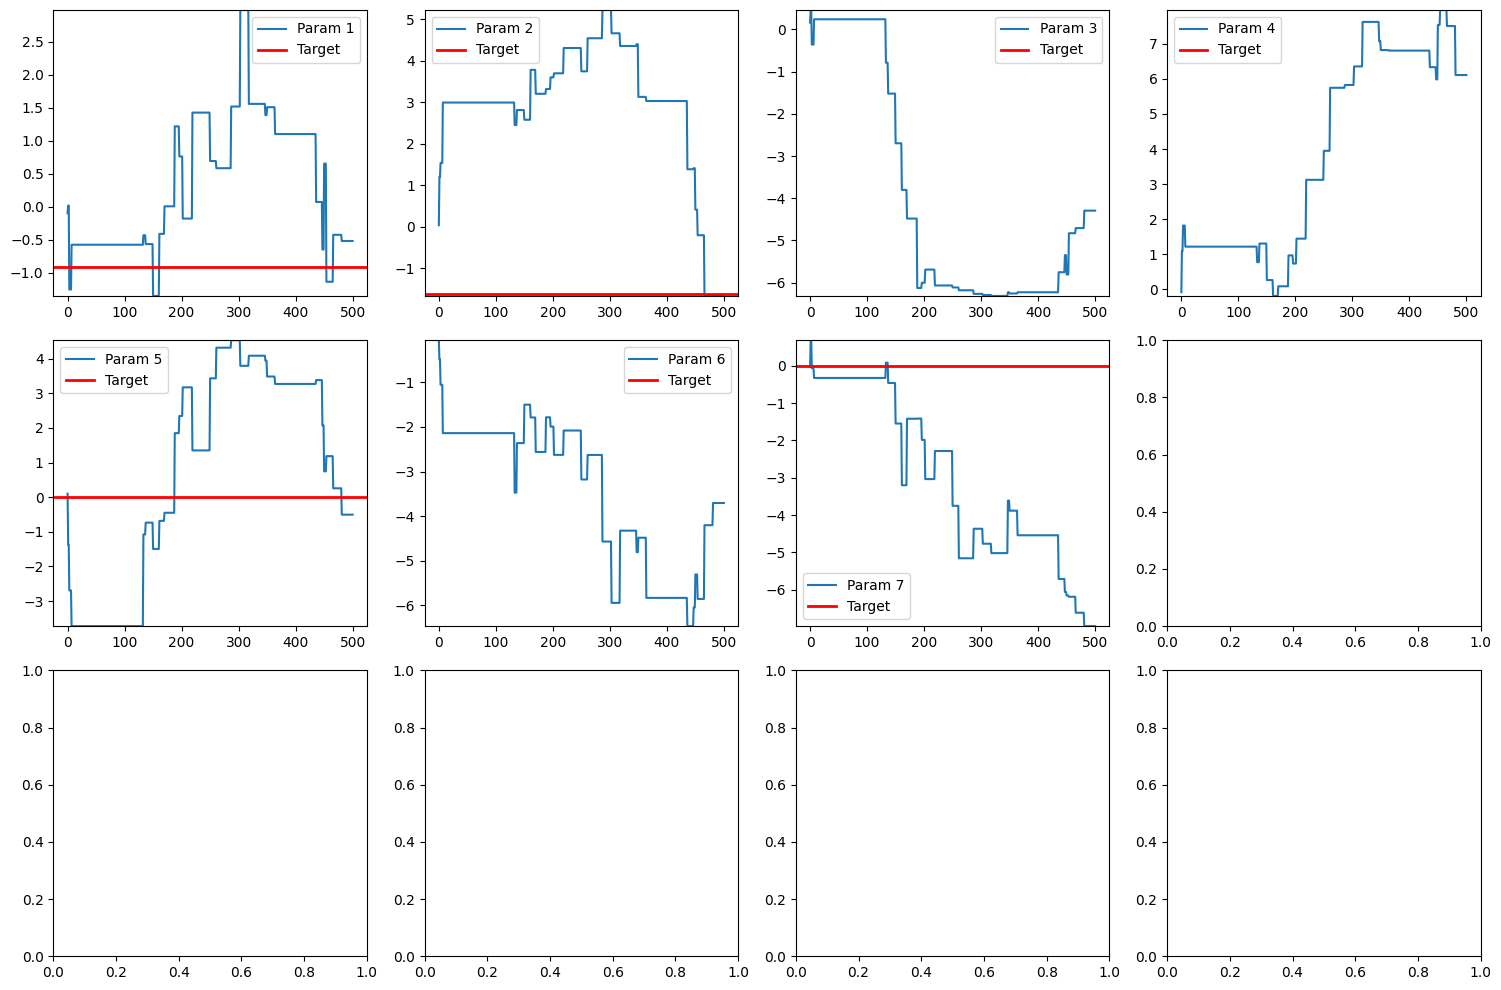

In [13]:
# Plotting parameter chains with target lines
fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 cols layout
axs = axs.flatten()

for par_num in range(num_params):
    ylim = (np.min(all_steps["chain"][par_num, :]), np.max(all_steps["chain"][par_num, :]))
    axs[par_num].plot(all_steps["chain"][par_num, :], label=f"Param {par_num+1}")
    axs[par_num].axhline(target_vector[par_num], color='red', linewidth=2, label="Target")
    axs[par_num].set_ylim(ylim)
    axs[par_num].legend()

plt.tight_layout()
plt.show()


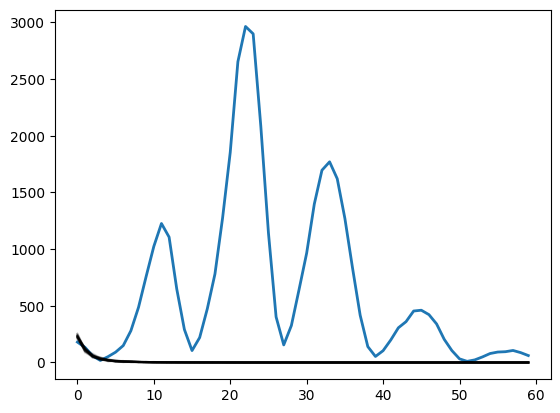

In [14]:
# Plot observed data
plt.figure()
plt.plot(data[:, 5], linewidth=2)  # data[,6] in R is data[:,5] in Python (0-indexed)

for _ in range(40):
    out = sir_out(all_steps["chain"][:, -1])
    plt.plot(out[:, 5], color=(0, 0, 0, 0.1))  # black with alpha=0.1

plt.show()

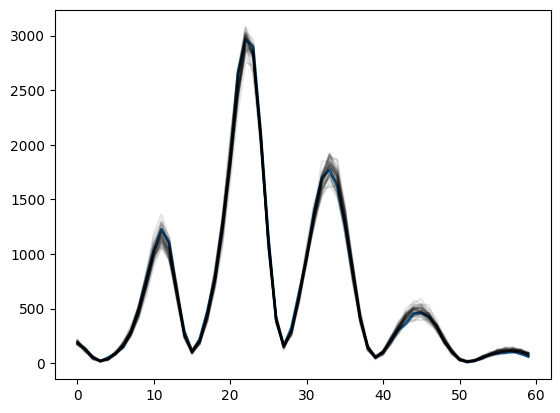

In [15]:
# Plot observed data again
plt.figure()
plt.plot(data[:, 5], linewidth=2)

for _ in range(40):
    out = sir_out(target_vector)
    plt.plot(out[:, 5], color=(0, 0, 0, 0.1))

plt.show()

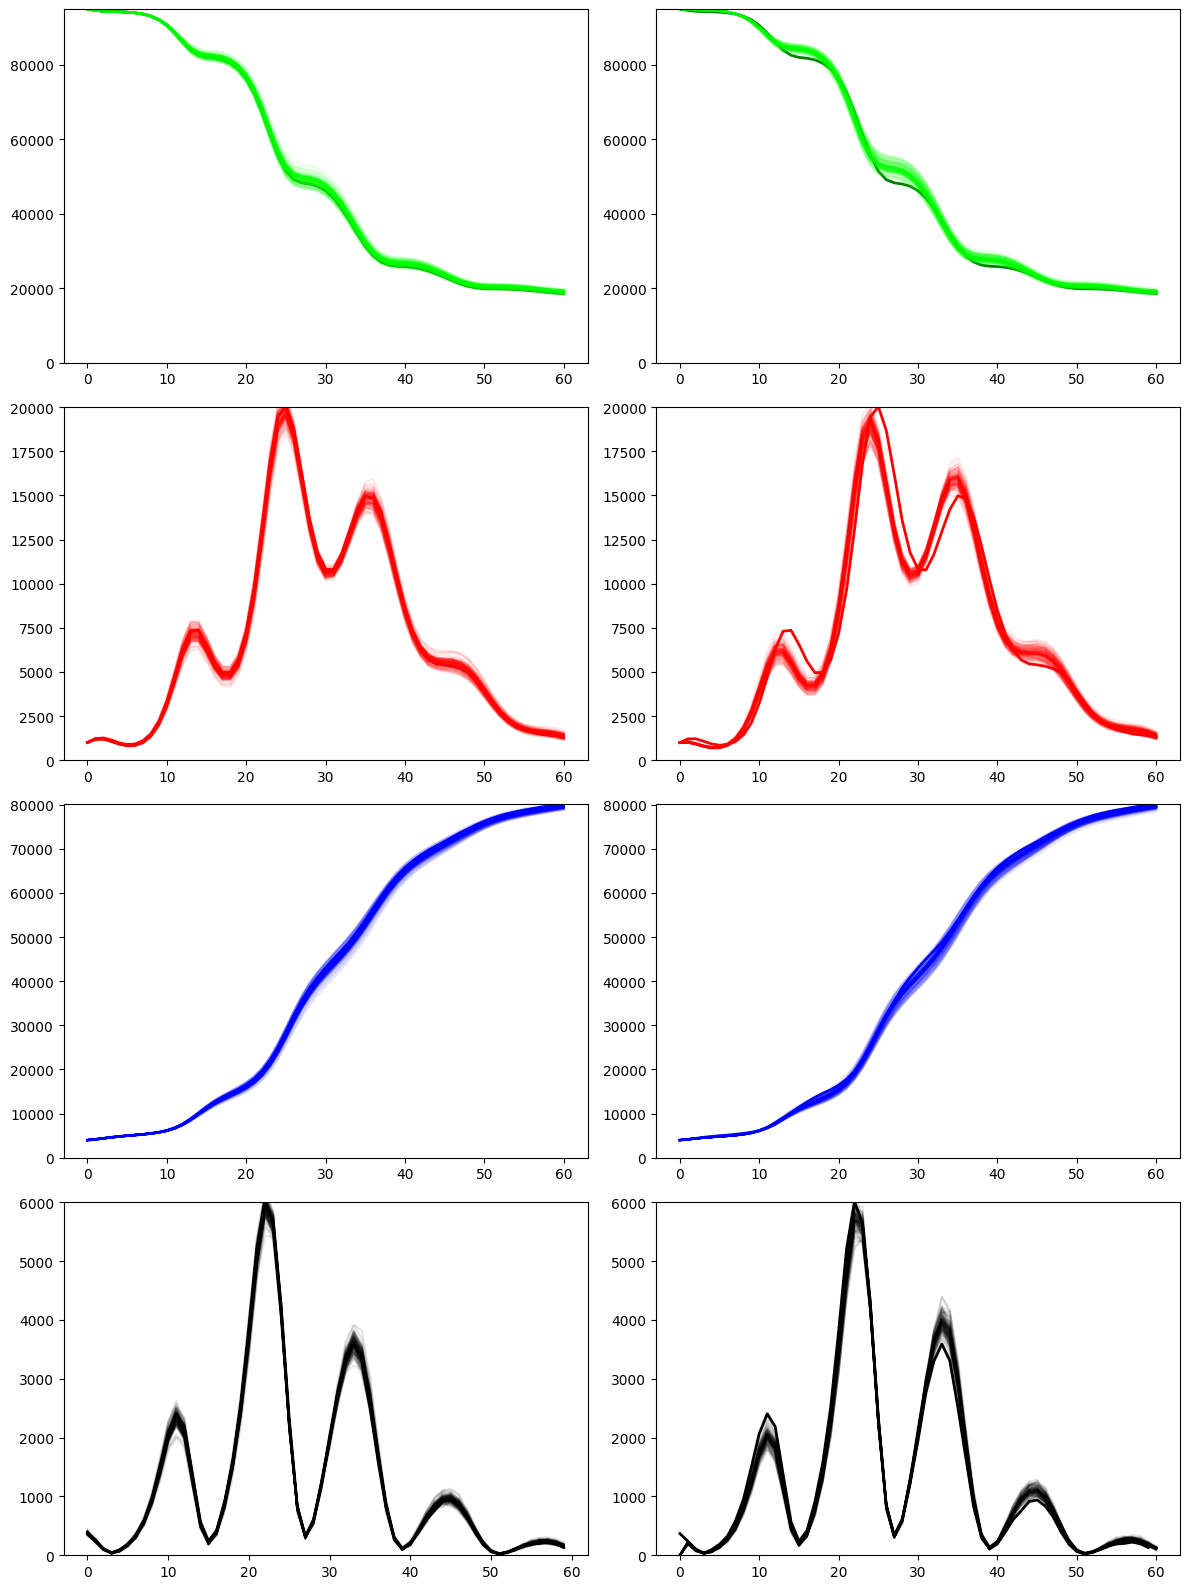

In [16]:
# Assuming sir_out and run_one_timestep are already defined in Python,
# and target_vector, data, num_particles, num_time_steps are available

# Generate list of SIR outputs for each particle
data_list = [sir_out(target_vector) for _ in range(num_particles)]

# Initialize array and simulate for all particles across time steps
sir_out_all_months = initialize_array(target_vector)  # shape: (num_particles, num_time_steps+1, 4)

for month_step in range(num_time_steps):
    sir_out_all_months[:, month_step + 1, :] = run_one_timestep(
        sir_out_all_months[:, month_step, :], month_step + 1, target_vector
    )

# Setup 4 rows x 2 columns of plots
fig, axs = plt.subplots(4, 2, figsize=(12, 16))
axs = axs.flatten()

colors = [
    (0, 1, 0, 0.1),  # green transparent
    (0, 1, 0, 0.1),  # green transparent
    (1, 0, 0, 0.1),  # red transparent
    (1, 0, 0, 0.1),  # red transparent
    (0, 0, 1, 0.1),  # blue transparent
    (0, 0, 1, 0.1),  # blue transparent
    (0, 0, 0, 0.1),  # black transparent
    (0, 0, 0, 0.1),  # black transparent
]

for i, col in enumerate([0, 0, 1, 1, 2, 2, 3, 3]):
    # Plot data line
    axs[i].plot(data[:, col], color=["green", "green", "red", "red", "blue", "blue", "black", "black"][i], linewidth=2)

    # Determine which list to draw from (even indices: data_list, odd: sir_out_all_months)
    if i % 2 == 0:
        for p_num in range(num_particles):
            axs[i].plot(data_list[p_num][:, col], color=colors[i])
    else:
        for p_num in range(num_particles):
            axs[i].plot(sir_out_all_months[p_num, :, col], color=colors[i])

    axs[i].set_ylim(0, np.nanmax(data[:, col]))

plt.tight_layout()
plt.show()
